In [1]:
import sys
sys.path.append("..")
sys.path.append("../dataset_parsers")


from models import OutcomeModel
from MIMIC3 import MIMIC_3
from utilities import *
from Processing import *
from graph_builders.diagnoses import DiagnosesGraph as Graph

import networkx as nx

ModuleNotFoundError: No module named 'graph_builders.base'

In [35]:
from ICDCodesGrouper import ICDCodesGrouper
icdgrouper = ICDCodesGrouper(ccs_path='CCS-SingleDiagnosisGrouper.txt',ccs_procedure_path='CCS-SingleProceduresGrouper.txt')

In [37]:
mimic_path =  "/notebooks/Experiments/Datasets/MIMIC 3/"
dataset = MIMIC_3(mimic_path,save_steps = True)

In [38]:
df = dataset.to_self_supervised(target_grouper = {"phenotype":lambda x: icdgrouper.lookup('ccs',x)})

df = df.sample(2000)


In [39]:
def multi_level_group(code,hierarchy):
    group = hierarchy[code]
    group = group.split('.')
    #print(group)
    return group[0]

In [40]:
tasks = ['phenotype']
from sklearn.preprocessing import MultiLabelBinarizer
all_classes = icdgrouper.get_classes('ccs')
mlb = MultiLabelBinarizer(classes=all_classes)
multi_hot = mlb.fit_transform(df.phenotype)
df.phenotype = list(multi_hot)
x = df.diagnoses.values
y ={}
for task in tasks:
    dim = len(np.array(list(df[task])).shape)
    y[task] = multi_hot


In [41]:
device = 'cpu'
embedding_size = 512
n_layer = 1
ancestry = 'no'
f_name = "CCS-MultiDiagnosisGrouper.txt"



In [42]:
G,idx,hierarchy = get_or_create_diagnosis_ccs_graph(nx.DiGraph(),f_name,connected=ancestry=='full',return_idx=True)

def load_model(device='cpu',n_layer=1,ancestry='full',embedding_size=512):
    model = OutcomeModel(embedding_size = embedding_size,n_layers=n_layer,output_pathway = [283])


    model.load_state_dict(torch.load(f"models/mimic/['diagnoses']/['phenotype']/normal/its:1/dropout/ccs/[283]/25/256/ancestry:{ancestry}/SW-Phenotype-{n_layer}-{embedding_size}",map_location='cpu'))

    model = model.to(device)
    model.eval()
    return model

This should never happen.. V173


In [43]:
#LOAD MODEL
model = load_model(device=device,n_layer=n_layer,ancestry=ancestry,embedding_size=embedding_size)

In [44]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [45]:
count_parameters(model)

20058395

In [46]:
%%time
embeddings = init_embeddings(embedding_size,poincare = True,G=G) 


CPU times: user 113 ms, sys: 114 ms, total: 227 ms
Wall time: 153 ms


In [47]:
%%time
validation = get_or_load_data(patients = x,target=y,G = G,embedding_size = embedding_size,graph_type=Graph,embeddings=embeddings,replicate=False,random=False).to(device)

CPU times: user 1min 21s, sys: 1min 13s, total: 2min 35s
Wall time: 26.7 s


In [48]:
validation = validation.to(device)

In [49]:
out = model(validation)
real = validation.target['phenotype']
validate(out,validation.target)

{'phenotype': {'R@5': array(0.15399168, dtype=float32),
  'P@5': array(0.1524, dtype=float32),
  'R@10': array(0.17839941, dtype=float32),
  'P@10': array(0.15670002, dtype=float32),
  'R@15': array(0.21546441, dtype=float32),
  'P@15': array(0.1508, dtype=float32),
  'R@20': array(0.25790143, dtype=float32),
  'P@20': array(0.14215, dtype=float32),
  'R@25': array(0.30120763, dtype=float32),
  'P@25': array(0.13392, dtype=float32),
  'R@30': array(0.3449939, dtype=float32),
  'P@30': array(0.12881666, dtype=float32)}}

### Clusters

In [50]:
from sklearn.manifold import TSNE

In [51]:
icd_embeddings = model.x[list(idx.values())]
#indices = torch.randperm(len(icd_embeddings))[:2000]
sample = icd_embeddings.detach().numpy()#[indices].detach().numpy()
keys = np.array(list(idx.keys()))
#keys = keys[indices]

In [52]:
%%time
X_embedded = TSNE(n_components=2).fit_transform(sample)

CPU times: user 3min 32s, sys: 4.43 s, total: 3min 36s
Wall time: 1min


In [53]:
%%time
ccs_grouped = [icdgrouper.lookup('ccs',str(item)) for item in keys]
multi_level_grouped = [multi_level_group(str(item),hierarchy) for item in keys]

CPU times: user 38.3 ms, sys: 544 µs, total: 38.8 ms
Wall time: 37.8 ms


In [54]:
group = multi_level_grouped

CPU times: user 68.8 ms, sys: 279 µs, total: 69.1 ms
Wall time: 68.2 ms


<AxesSubplot:xlabel='0', ylabel='1'>

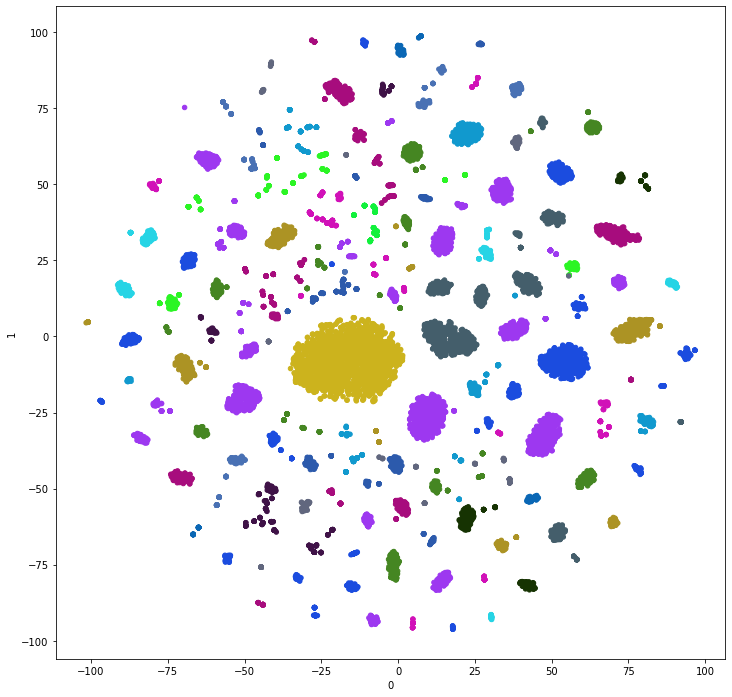

In [55]:
%%time
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(len(set(group)))]
color = pd.DataFrame(data={'color':color,'group':list(set(group))})
cf = pd.DataFrame(group).set_index(0).merge(color,right_on='group',left_index=True)
pd.DataFrame(X_embedded).plot(kind='scatter',x=0,y=1,c = cf.color,figsize=(12,12))

<AxesSubplot:xlabel='0', ylabel='1'>

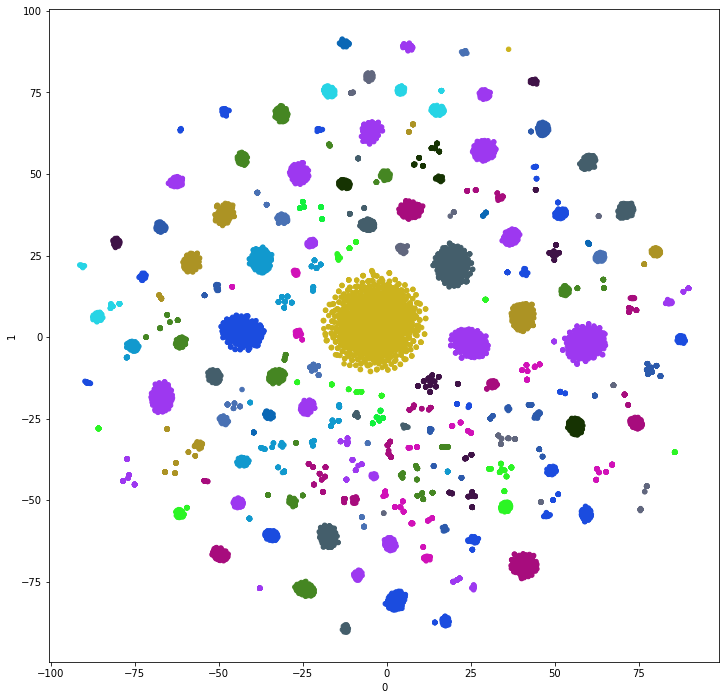

In [56]:
from gensim.models.poincare import PoincareModel

model = PoincareModel.load(f'./embeddings/diagnosis-poincare-512')
icd_embeddings = model.kv.get_normed_vectors()[list(idx.values())]
keys = np.array(list(idx.keys()))
X_embedded = TSNE(n_components=2).fit_transform(icd_embeddings)
#color = pd.DataFrame(data={'color':color,'group':list(set(group))})
cf = pd.DataFrame(group).set_index(0).merge(color,right_on='group',left_index=True)
pd.DataFrame(X_embedded).plot(kind='scatter',x=0,y=1,c = cf.color,figsize=(12,12))

### Prediction Statistics

In [57]:
all_classes = icdgrouper.get_classes('ccs')

patient = lambda x: all_classes[out[0].argsort(axis=1,descending=True)[x]]

In [58]:
df

,diagnoses,phenotype
SUBJECT_ID,,
4290,"[[0389, 51881, 5070, 78552, 3453, 27787, 2762,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1319,"[[7742, 76527, 76517, V053, V502]]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
86146,"[[29181, 2639, 78039, 5710, 30390, 2875, 9210,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
27132,"[[5109, 486, 51181, 4233, 1985, 51881, 4238, V...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
58965,"[[2761, 73300, 27652, 78701]]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
81020,"[[1623, 3485, 1983, 27651, 78701, 79029, E9320...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5193,"[[41041, 78551, 4271, 99812, 41401, 42731, 250...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
20007,"[[51881, 5601, 42731, 4821, 5990, 00845, 4280,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [59]:
def get_names(sort_tensor,lookup):
    res = []
    for item in sort_tensor:
        res.append(lookup[item])
    return res


In [60]:
res = [get_names(patient(i),icdgrouper.ccs.names) for i in range(df.shape[0])]

In [61]:
df = pd.DataFrame(res)


<AxesSubplot:ylabel='0'>

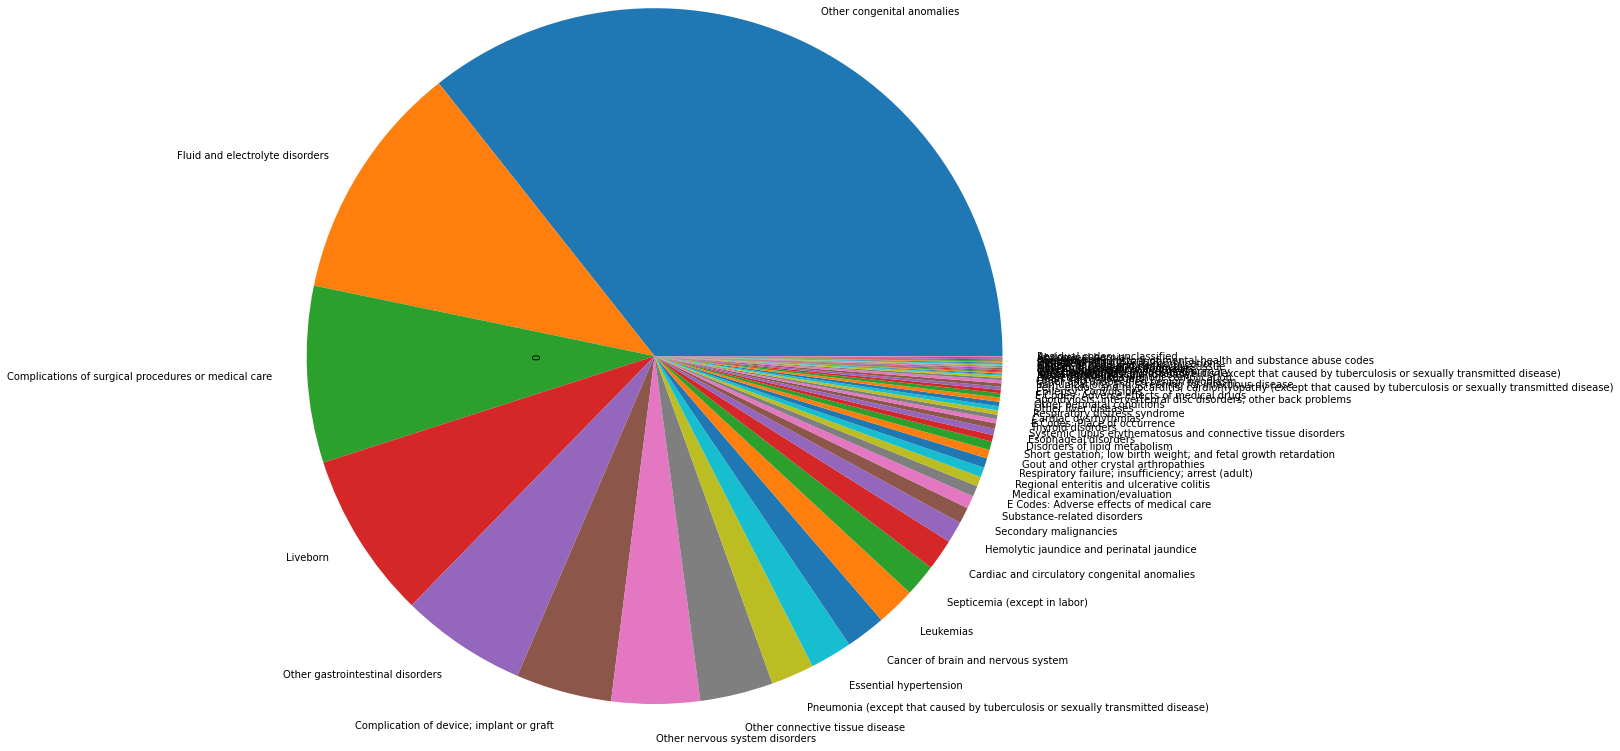

In [62]:
(df[0].value_counts()/df[0].value_counts().sum()).plot(kind='pie',radius=4)

<AxesSubplot:ylabel='1'>

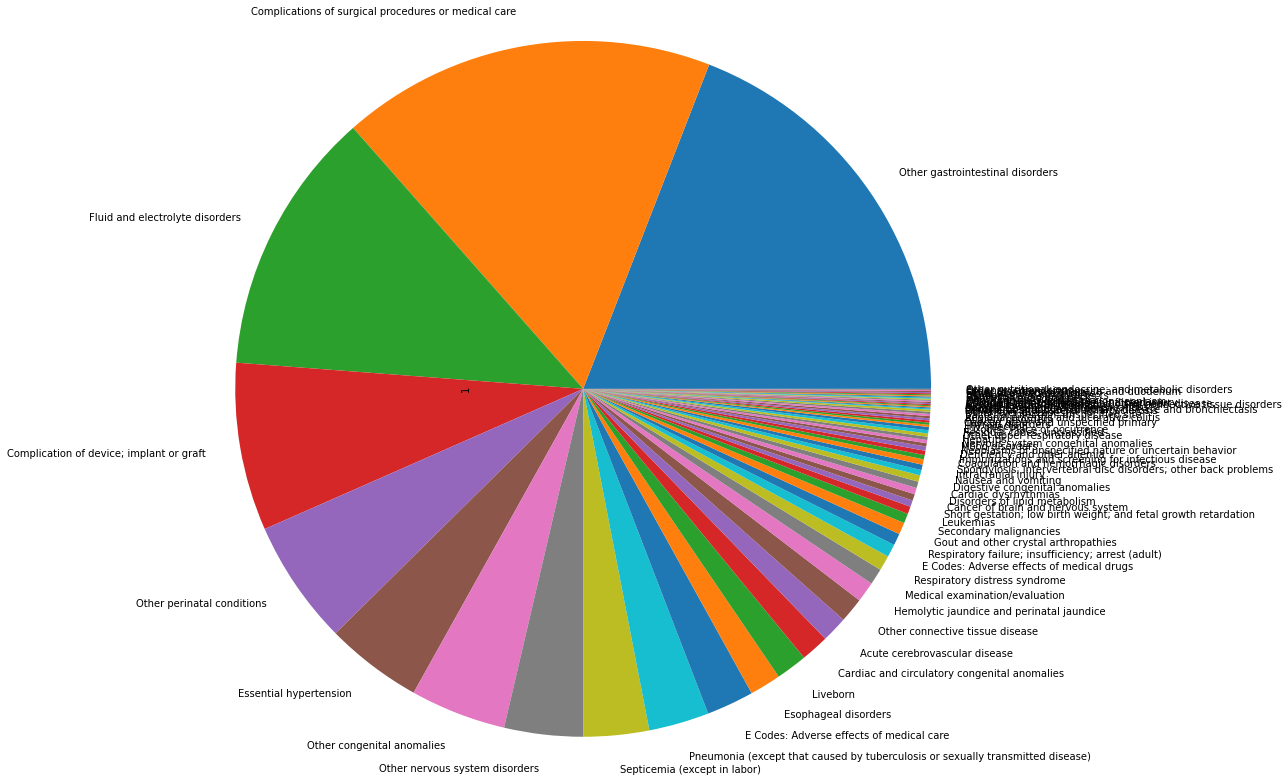

In [63]:
(df[1].value_counts()/df[0].value_counts().sum()).plot(kind='pie',radius=4)

<AxesSubplot:>

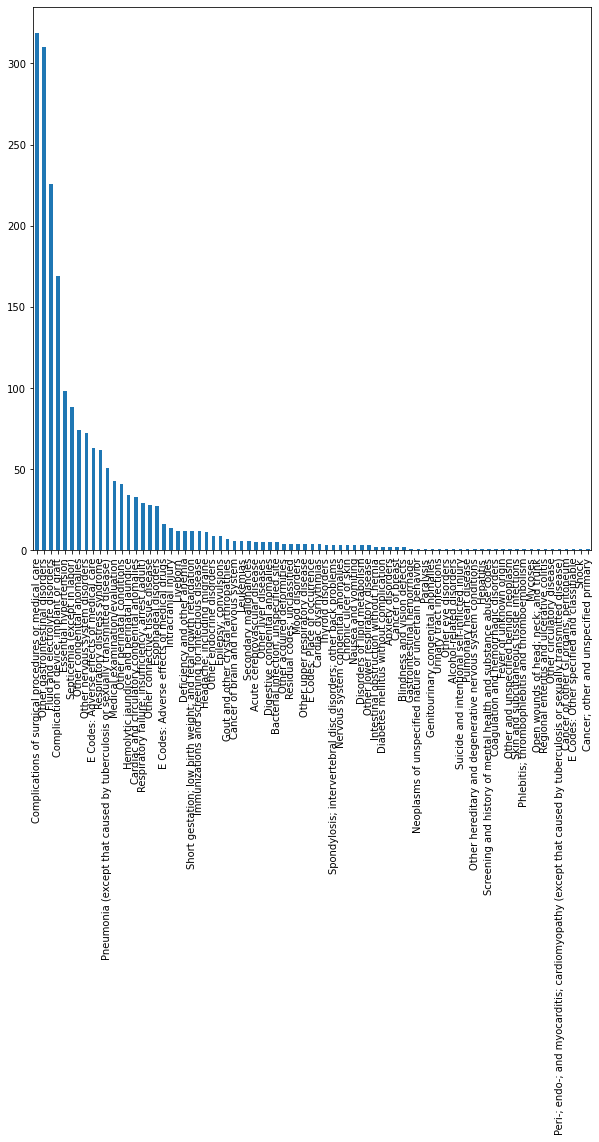

In [64]:
df[2].value_counts().plot(kind='bar',figsize=(10,10))

In [65]:
#import validate, and check the 'normal metrics'
#check 'few-shot' metrics
from utilities import validate

In [66]:
validate(out,validation.target)

{'phenotype': {'R@5': array(0.15399168, dtype=float32),
  'P@5': array(0.1524, dtype=float32),
  'R@10': array(0.17839941, dtype=float32),
  'P@10': array(0.15670002, dtype=float32),
  'R@15': array(0.21546441, dtype=float32),
  'P@15': array(0.1508, dtype=float32),
  'R@20': array(0.25790143, dtype=float32),
  'P@20': array(0.14215, dtype=float32),
  'R@25': array(0.30120763, dtype=float32),
  'P@25': array(0.13392, dtype=float32),
  'R@30': array(0.3449939, dtype=float32),
  'P@30': array(0.12881666, dtype=float32)}}

### Similarity
#### Cosine


In [67]:
from sklearn.metrics.pairwise import cosine_similarity,PAIRWISE_DISTANCE_FUNCTIONS

In [68]:
pred = out[0].detach().cpu().numpy()
pred

array([[2.3761032e-04, 1.9205414e-02, 7.4897618e-03, ..., 5.3681911e-04,
        8.0361689e-04, 1.1881232e-02],
       [1.0032820e-04, 4.4100909e-03, 1.2141829e-02, ..., 2.4620658e-03,
        2.1445449e-03, 1.6266149e-02],
       [9.9360815e-04, 1.2157033e-02, 1.2161701e-02, ..., 3.7220113e-03,
        2.2104215e-03, 1.0130596e-02],
       ...,
       [2.8719002e-04, 1.1899442e-02, 1.6274698e-02, ..., 8.4294763e-04,
        1.0422559e-03, 8.2724141e-03],
       [9.9546356e-05, 1.7828092e-02, 1.4152948e-02, ..., 7.2309609e-05,
        7.7670283e-04, 1.2369076e-02],
       [4.9986911e-04, 2.1723758e-02, 1.9762639e-02, ..., 1.2501264e-03,
        2.5693171e-03, 7.7205556e-03]], dtype=float32)

In [69]:
%%time
similarities = cosine_similarity(pred)

CPU times: user 47.3 ms, sys: 7.97 ms, total: 55.3 ms
Wall time: 14.3 ms


In [70]:
similarities.argsort()[:,::-1][:,1:] #ordered more similar - less similar, remove first column


array([[1098, 1795,  386, ..., 1240, 1938, 1354],
       [1448,  825,  318, ...,  916, 1354, 1938],
       [1080, 1826,  222, ..., 1240, 1938, 1354],
       ...,
       [1988,   73,  566, ..., 1938, 1240, 1354],
       [1619,  374,   23, ..., 1938, 1240, 1354],
       [1449,  319, 1414, ..., 1240, 1938, 1354]])

#### Tsne

In [71]:
from sklearn.manifold import TSNE

In [73]:
X_embedded  = TSNE(n_components=2).fit_transform(model.x.detach().numpy())
pd.DataFrame(X_embedded).plot(kind='scatter',x=0,y=1,figsize=(10,10))

AttributeError: 'PoincareModel' object has no attribute 'x'

### Poincaré

In [ ]:
from gensim.models.poincare import PoincareModel

embedding_size=512
model = PoincareModel.load(f'./embeddings/diagnosis-poincare-{embedding_size}')


In [ ]:
def kv_distance(first,second):
    total = 0
    cnt = 0
    for j in first:
        for k in second:
            total = total + model.kv.distance(j,k)
            cnt = cnt + 1
    return total/cnt

def patient_distance(first,second):
    total = 0
    cnt = 0
    for j in first:
        for k in second:
            total = total + kv_distance(j,k)
            cnt = cnt + 1
    return total/cnt
def cohort_distance(lst):
    res = []
    for idj,j in enumerate(lst):
        temp = []
        for idk,k in enumerate(lst):
            temp.append(patient_distance(j,k))
        res.append(temp)
    return res #return same patient comparison (how similar its trajectory is ?)
            
    

In [ ]:
%%time
cohort_distance(df.diagnoses.iloc[:5])

### Trajectory

In [75]:
#Compare visit per visit
#How someone 'changes' throughout their visits ? 

Few-shot stuff

In [76]:
y_pred = out[0]

In [77]:
y_real = validation.target['phenotype']

In [78]:
k = 20
sort = y_pred.sort(axis=1,descending=True)
y_pred = sort.indices[:,0:k]
top_k = y_real.gather(1,y_pred)

In [79]:
(sort.indices == 0).sum()

tensor(2000)

In [80]:
#y_pred.argsort(axis=1,descending=True)

In [81]:
#rel = (y_pred*top_k).flatten()[(y_pred*top_k).flatten()!=0]

In [82]:
#div = torch.clamp(y_real.sum(dim=1),max=k)
#div

In [83]:
#percentile.iloc[y_real.detach().cpu().numpy()]

In [84]:
df = pd.DataFrame(y_real.detach().cpu().numpy())

In [85]:
df.columns = percentile[0].values

NameError: name 'percentile' is not defined

In [86]:
df.T.groupby(df.T.index).apply(sum) #column = patients, index = percentiles

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#[0,1,0,1] -> [0,0-20,0,0-20], r:[0, 0-20,0,40-60]

In [ ]:
df = df.T.groupby(df.T.index).apply(sum)
df


In [ ]:
pred = pd.DataFrame((y_pred).detach().cpu().numpy()).astype(int)

In [ ]:
lookup =percentile.reset_index()

In [ ]:
icdgrouper.get_classes('ccs')[89]

In [ ]:
pred = pred.applymap(lambda x: lookup.iloc[x][0])


In [ ]:
def confirm(x):
    results = {"0-20":0,"20-40":0,"40-60":0,"60-80":0,"80-100":0}
    idx = x.name
    real = top_k[idx]
    res = []
    for idx,item in enumerate(x):
        results[item] +=real[idx].numpy()
    return results

In [ ]:
pred = pred.apply(confirm,axis=1).apply(pd.Series)

In [ ]:
pred

In [ ]:
stats = (pred/df.T).fillna(0)

In [ ]:
stats

In [ ]:
stats.describe()

In [ ]:
pred.sum()
#j'ai confuse on the meaning of these valueeesss